In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='6'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='std_temp'
SAMPLE_SIZE=5000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_6_20250330_2303


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 142619/142619 [01:05<00:00, 2165.15it/s]

Saved 142619 profiles to /workspace/outputs/profiles_v1_experiment_6_20250330_2303/20250330-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 142619it [00:05, 26440.01it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250330_2303/density_plot.png


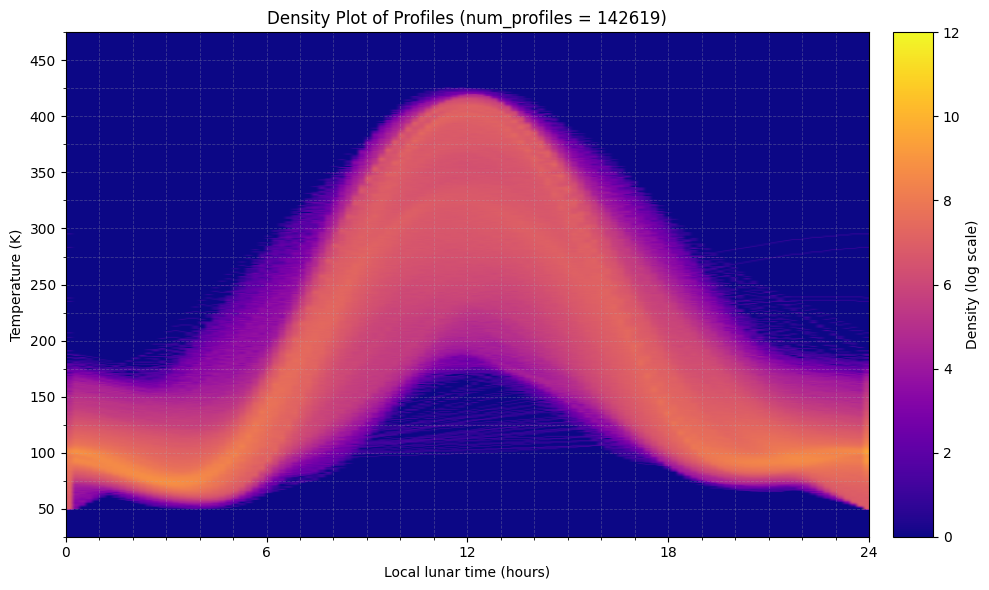

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250330_2303/histogram_max_temp.png


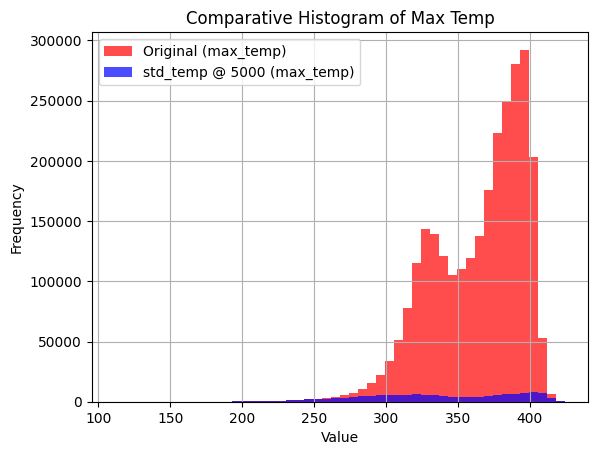

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250330_2303/histogram_min_temp.png


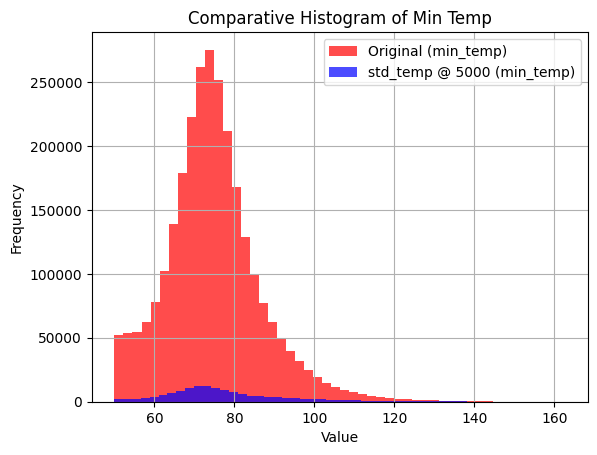

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250330_2303/histogram_mean_temp.png


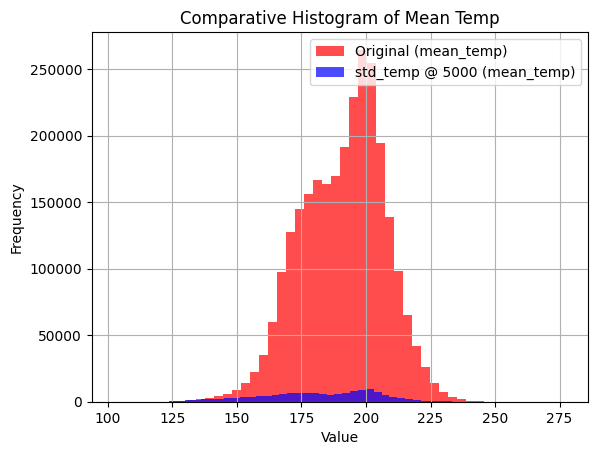

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250330_2303/histogram_std_temp.png


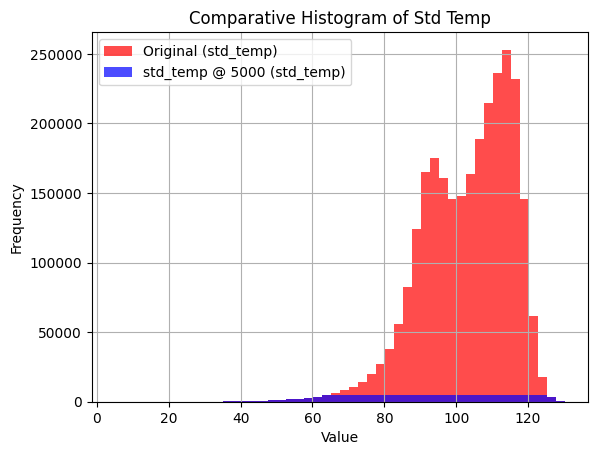

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 181.0313
STD: 96.0749
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 99833
Validation Data: 28523
Test Data: 14263


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 500/500 [00:15<00:00, 31.87it/s, best_loss=0.5916]


[Training] Epoch 1/100, L1 Loss: 0.6286, L2 Loss: 0.6423, KL Loss: 0.4809, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 143/143 [00:01<00:00, 115.24it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5187, Val L2 Loss: 0.4965, Val KL Loss: 0.6230
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250330_2303'


[Training] Epoch 2/100: 100%|██████████| 500/500 [00:15<00:00, 31.48it/s, best_loss=0.5435]


[Training] Epoch 2/100, L1 Loss: 0.5626, L2 Loss: 0.5434, KL Loss: 0.6157, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 143/143 [00:01<00:00, 118.02it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5164, Val L2 Loss: 0.4941, Val KL Loss: 0.6169
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250330_2303'


[Training] Epoch 3/100: 100%|██████████| 500/500 [00:15<00:00, 32.94it/s, best_loss=0.5791]


[Training] Epoch 3/100, L1 Loss: 0.5620, L2 Loss: 0.5426, KL Loss: 0.6160, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 143/143 [00:01<00:00, 116.56it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5151, Val L2 Loss: 0.4930, Val KL Loss: 0.6215
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250330_2303'


[Training] Epoch 4/100: 100%|██████████| 500/500 [00:14<00:00, 34.73it/s, best_loss=0.5591]


[Training] Epoch 4/100, L1 Loss: 0.5615, L2 Loss: 0.5421, KL Loss: 0.6161, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 143/143 [00:01<00:00, 132.40it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5158, Val L2 Loss: 0.4934, Val KL Loss: 0.6216


[Training] Epoch 5/100: 100%|██████████| 500/500 [00:15<00:00, 33.13it/s, best_loss=0.5764]


[Training] Epoch 5/100, L1 Loss: 0.5617, L2 Loss: 0.5422, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 143/143 [00:01<00:00, 95.45it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5206, Val L2 Loss: 0.4972, Val KL Loss: 0.6048


[Training] Epoch 6/100: 100%|██████████| 500/500 [00:15<00:00, 32.60it/s, best_loss=0.5730]


[Training] Epoch 6/100, L1 Loss: 0.5618, L2 Loss: 0.5424, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 143/143 [00:01<00:00, 114.17it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.4956, Val KL Loss: 0.6064


[Training] Epoch 7/100: 100%|██████████| 500/500 [00:15<00:00, 33.11it/s, best_loss=0.5631]


[Training] Epoch 7/100, L1 Loss: 0.5615, L2 Loss: 0.5419, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 143/143 [00:01<00:00, 105.74it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5262, Val L2 Loss: 0.5017, Val KL Loss: 0.5914


[Training] Epoch 8/100: 100%|██████████| 500/500 [00:15<00:00, 32.58it/s, best_loss=0.5543]


[Training] Epoch 8/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 143/143 [00:01<00:00, 108.97it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5204, Val L2 Loss: 0.4974, Val KL Loss: 0.6066


[Training] Epoch 9/100: 100%|██████████| 500/500 [00:15<00:00, 33.19it/s, best_loss=0.5738]


[Training] Epoch 9/100, L1 Loss: 0.5616, L2 Loss: 0.5419, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 143/143 [00:01<00:00, 91.89it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5242, Val L2 Loss: 0.4998, Val KL Loss: 0.5997


[Training] Epoch 10/100: 100%|██████████| 500/500 [00:15<00:00, 33.02it/s, best_loss=0.5599]


[Training] Epoch 10/100, L1 Loss: 0.5613, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 143/143 [00:01<00:00, 120.67it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5239, Val L2 Loss: 0.5002, Val KL Loss: 0.5975


[Training] Epoch 11/100: 100%|██████████| 500/500 [00:15<00:00, 32.24it/s, best_loss=0.5678]


[Training] Epoch 11/100, L1 Loss: 0.5618, L2 Loss: 0.5426, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 143/143 [00:01<00:00, 104.08it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5160, Val L2 Loss: 0.4935, Val KL Loss: 0.6207


[Training] Epoch 12/100: 100%|██████████| 500/500 [00:15<00:00, 33.16it/s, best_loss=0.5755]


[Training] Epoch 12/100, L1 Loss: 0.5619, L2 Loss: 0.5425, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 143/143 [00:01<00:00, 111.78it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.4932, Val KL Loss: 0.6160


[Training] Epoch 13/100: 100%|██████████| 500/500 [00:15<00:00, 32.08it/s, best_loss=0.5859]


[Training] Epoch 13/100, L1 Loss: 0.5616, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 143/143 [00:01<00:00, 108.71it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.4988, Val KL Loss: 0.5994


[Training] Epoch 14/100: 100%|██████████| 500/500 [00:15<00:00, 33.03it/s, best_loss=0.5593]


[Training] Epoch 14/100, L1 Loss: 0.5619, L2 Loss: 0.5425, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 143/143 [00:01<00:00, 110.86it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5211, Val L2 Loss: 0.4974, Val KL Loss: 0.5993


[Training] Epoch 15/100: 100%|██████████| 500/500 [00:15<00:00, 32.79it/s, best_loss=0.5749]


[Training] Epoch 15/100, L1 Loss: 0.5616, L2 Loss: 0.5422, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 143/143 [00:01<00:00, 110.27it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5237, Val L2 Loss: 0.4999, Val KL Loss: 0.5967


[Training] Epoch 16/100: 100%|██████████| 500/500 [00:15<00:00, 33.11it/s, best_loss=0.5553]


[Training] Epoch 16/100, L1 Loss: 0.5617, L2 Loss: 0.5422, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 143/143 [00:01<00:00, 127.01it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.4978, Val KL Loss: 0.6047


[Training] Epoch 17/100: 100%|██████████| 500/500 [00:15<00:00, 33.12it/s, best_loss=0.5736]


[Training] Epoch 17/100, L1 Loss: 0.5620, L2 Loss: 0.5428, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 143/143 [00:01<00:00, 114.48it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5142, Val L2 Loss: 0.4920, Val KL Loss: 0.6356
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250330_2303'


[Training] Epoch 18/100: 100%|██████████| 500/500 [00:15<00:00, 31.67it/s, best_loss=0.5754]


[Training] Epoch 18/100, L1 Loss: 0.5616, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 143/143 [00:01<00:00, 118.85it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5162, Val L2 Loss: 0.4937, Val KL Loss: 0.6176


[Training] Epoch 19/100: 100%|██████████| 500/500 [00:15<00:00, 32.94it/s, best_loss=0.5562]


[Training] Epoch 19/100, L1 Loss: 0.5617, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 143/143 [00:01<00:00, 112.55it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5243, Val L2 Loss: 0.5001, Val KL Loss: 0.5965


[Training] Epoch 20/100: 100%|██████████| 500/500 [00:15<00:00, 32.39it/s, best_loss=0.5845]


[Training] Epoch 20/100, L1 Loss: 0.5615, L2 Loss: 0.5420, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 143/143 [00:01<00:00, 121.76it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5157, Val L2 Loss: 0.4931, Val KL Loss: 0.6234


[Training] Epoch 21/100: 100%|██████████| 500/500 [00:14<00:00, 33.34it/s, best_loss=0.5568]


[Training] Epoch 21/100, L1 Loss: 0.5619, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 143/143 [00:01<00:00, 119.01it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5168, Val L2 Loss: 0.4942, Val KL Loss: 0.6161


[Training] Epoch 22/100: 100%|██████████| 500/500 [00:15<00:00, 32.80it/s, best_loss=0.5610]


[Training] Epoch 22/100, L1 Loss: 0.5617, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 143/143 [00:01<00:00, 110.65it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.5033, Val KL Loss: 0.5835


[Training] Epoch 23/100: 100%|██████████| 500/500 [00:15<00:00, 32.71it/s, best_loss=0.5741]


[Training] Epoch 23/100, L1 Loss: 0.5613, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 143/143 [00:01<00:00, 128.36it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5198, Val L2 Loss: 0.4966, Val KL Loss: 0.6052


[Training] Epoch 24/100: 100%|██████████| 500/500 [00:15<00:00, 32.10it/s, best_loss=0.5517]


[Training] Epoch 24/100, L1 Loss: 0.5615, L2 Loss: 0.5419, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 143/143 [00:01<00:00, 108.22it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5186, Val L2 Loss: 0.4953, Val KL Loss: 0.6173


[Training] Epoch 25/100: 100%|██████████| 500/500 [00:15<00:00, 33.20it/s, best_loss=0.5598]


[Training] Epoch 25/100, L1 Loss: 0.5614, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 143/143 [00:01<00:00, 127.25it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5180, Val L2 Loss: 0.4953, Val KL Loss: 0.6128


[Training] Epoch 26/100: 100%|██████████| 500/500 [00:15<00:00, 32.63it/s, best_loss=0.5721]


[Training] Epoch 26/100, L1 Loss: 0.5613, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 143/143 [00:01<00:00, 109.74it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5220, Val L2 Loss: 0.4987, Val KL Loss: 0.5946


[Training] Epoch 27/100: 100%|██████████| 500/500 [00:15<00:00, 32.52it/s, best_loss=0.5895]


[Training] Epoch 27/100, L1 Loss: 0.5617, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 143/143 [00:01<00:00, 122.39it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5195, Val L2 Loss: 0.4962, Val KL Loss: 0.6116


[Training] Epoch 28/100: 100%|██████████| 500/500 [00:15<00:00, 31.74it/s, best_loss=0.5586]


[Training] Epoch 28/100, L1 Loss: 0.5617, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 143/143 [00:01<00:00, 101.44it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5189, Val L2 Loss: 0.4957, Val KL Loss: 0.6060


[Training] Epoch 29/100: 100%|██████████| 500/500 [00:15<00:00, 32.93it/s, best_loss=0.5763]


[Training] Epoch 29/100, L1 Loss: 0.5618, L2 Loss: 0.5424, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 143/143 [00:01<00:00, 110.14it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5175, Val L2 Loss: 0.4950, Val KL Loss: 0.6066


[Training] Epoch 30/100: 100%|██████████| 500/500 [00:15<00:00, 33.11it/s, best_loss=0.5637]


[Training] Epoch 30/100, L1 Loss: 0.5620, L2 Loss: 0.5425, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 143/143 [00:01<00:00, 116.91it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.4934, Val KL Loss: 0.6170


[Training] Epoch 31/100: 100%|██████████| 500/500 [00:14<00:00, 33.40it/s, best_loss=0.5719]


[Training] Epoch 31/100, L1 Loss: 0.5616, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 143/143 [00:01<00:00, 128.47it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5207, Val L2 Loss: 0.4972, Val KL Loss: 0.6023


[Training] Epoch 32/100: 100%|██████████| 500/500 [00:15<00:00, 31.98it/s, best_loss=0.5686]


[Training] Epoch 32/100, L1 Loss: 0.5617, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 143/143 [00:01<00:00, 109.94it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5247, Val L2 Loss: 0.5003, Val KL Loss: 0.5980


[Training] Epoch 33/100: 100%|██████████| 500/500 [00:15<00:00, 32.79it/s, best_loss=0.5710]


[Training] Epoch 33/100, L1 Loss: 0.5613, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 143/143 [00:01<00:00, 124.90it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5178, Val L2 Loss: 0.4950, Val KL Loss: 0.6056


[Training] Epoch 34/100: 100%|██████████| 500/500 [00:15<00:00, 32.75it/s, best_loss=0.5530]


[Training] Epoch 34/100, L1 Loss: 0.5617, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 143/143 [00:01<00:00, 108.46it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5196, Val L2 Loss: 0.4964, Val KL Loss: 0.5987


[Training] Epoch 35/100: 100%|██████████| 500/500 [00:15<00:00, 31.37it/s, best_loss=0.5591]


[Training] Epoch 35/100, L1 Loss: 0.5616, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 143/143 [00:01<00:00, 106.16it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5210, Val L2 Loss: 0.4976, Val KL Loss: 0.5996


[Training] Epoch 36/100: 100%|██████████| 500/500 [00:16<00:00, 30.58it/s, best_loss=0.5660]


[Training] Epoch 36/100, L1 Loss: 0.5614, L2 Loss: 0.5420, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 143/143 [00:01<00:00, 102.65it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5170, Val L2 Loss: 0.4943, Val KL Loss: 0.6185


[Training] Epoch 37/100: 100%|██████████| 500/500 [00:16<00:00, 30.92it/s, best_loss=0.5724]


[Training] Epoch 37/100, L1 Loss: 0.5613, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 143/143 [00:01<00:00, 92.90it/s] 


[Validation] Epoch 37/100, Val L1 Loss: 0.5165, Val L2 Loss: 0.4941, Val KL Loss: 0.6187


[Training] Epoch 38/100: 100%|██████████| 500/500 [00:16<00:00, 30.81it/s, best_loss=0.5724]


[Training] Epoch 38/100, L1 Loss: 0.5618, L2 Loss: 0.5421, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 143/143 [00:01<00:00, 94.55it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5251, Val L2 Loss: 0.5011, Val KL Loss: 0.5952


[Training] Epoch 39/100: 100%|██████████| 500/500 [00:16<00:00, 30.68it/s, best_loss=0.5748]


[Training] Epoch 39/100, L1 Loss: 0.5616, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 143/143 [00:01<00:00, 93.53it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5189, Val L2 Loss: 0.4960, Val KL Loss: 0.6059


[Training] Epoch 40/100: 100%|██████████| 500/500 [00:16<00:00, 30.58it/s, best_loss=0.5689]


[Training] Epoch 40/100, L1 Loss: 0.5612, L2 Loss: 0.5414, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 143/143 [00:01<00:00, 106.81it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5178, Val L2 Loss: 0.4949, Val KL Loss: 0.6128


[Training] Epoch 41/100: 100%|██████████| 500/500 [00:16<00:00, 31.17it/s, best_loss=0.5487]


[Training] Epoch 41/100, L1 Loss: 0.5617, L2 Loss: 0.5420, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 143/143 [00:01<00:00, 113.10it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5192, Val L2 Loss: 0.4962, Val KL Loss: 0.6085


[Training] Epoch 42/100: 100%|██████████| 500/500 [00:16<00:00, 30.56it/s, best_loss=0.5556]


[Training] Epoch 42/100, L1 Loss: 0.5615, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 143/143 [00:01<00:00, 106.65it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5212, Val L2 Loss: 0.4978, Val KL Loss: 0.6057


[Training] Epoch 43/100: 100%|██████████| 500/500 [00:16<00:00, 30.30it/s, best_loss=0.5874]


[Training] Epoch 43/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 143/143 [00:01<00:00, 101.54it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5178, Val L2 Loss: 0.4949, Val KL Loss: 0.6119


[Training] Epoch 44/100: 100%|██████████| 500/500 [00:16<00:00, 30.23it/s, best_loss=0.5785]


[Training] Epoch 44/100, L1 Loss: 0.5618, L2 Loss: 0.5424, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 143/143 [00:01<00:00, 100.98it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5168, Val L2 Loss: 0.4944, Val KL Loss: 0.6167


[Training] Epoch 45/100: 100%|██████████| 500/500 [00:16<00:00, 29.87it/s, best_loss=0.5599]


[Training] Epoch 45/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 143/143 [00:01<00:00, 97.14it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5173, Val L2 Loss: 0.4944, Val KL Loss: 0.6171


[Training] Epoch 46/100: 100%|██████████| 500/500 [00:16<00:00, 30.09it/s, best_loss=0.5541]


[Training] Epoch 46/100, L1 Loss: 0.5614, L2 Loss: 0.5419, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 143/143 [00:01<00:00, 95.63it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5197, Val L2 Loss: 0.4965, Val KL Loss: 0.6091


[Training] Epoch 47/100: 100%|██████████| 500/500 [00:16<00:00, 30.47it/s, best_loss=0.5645]


[Training] Epoch 47/100, L1 Loss: 0.5614, L2 Loss: 0.5420, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 143/143 [00:01<00:00, 98.93it/s] 


[Validation] Epoch 47/100, Val L1 Loss: 0.5187, Val L2 Loss: 0.4957, Val KL Loss: 0.6112


[Training] Epoch 48/100: 100%|██████████| 500/500 [00:16<00:00, 29.96it/s, best_loss=0.5770]


[Training] Epoch 48/100, L1 Loss: 0.5614, L2 Loss: 0.5416, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 143/143 [00:01<00:00, 107.26it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5253, Val L2 Loss: 0.5008, Val KL Loss: 0.5890


[Training] Epoch 49/100: 100%|██████████| 500/500 [00:16<00:00, 30.60it/s, best_loss=0.5620]


[Training] Epoch 49/100, L1 Loss: 0.5615, L2 Loss: 0.5420, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 143/143 [00:01<00:00, 93.80it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5165, Val L2 Loss: 0.4939, Val KL Loss: 0.6176


[Training] Epoch 50/100: 100%|██████████| 500/500 [00:16<00:00, 29.96it/s, best_loss=0.5631]


[Training] Epoch 50/100, L1 Loss: 0.5615, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 143/143 [00:01<00:00, 94.75it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5180, Val L2 Loss: 0.4949, Val KL Loss: 0.6149


[Training] Epoch 51/100: 100%|██████████| 500/500 [00:16<00:00, 30.52it/s, best_loss=0.5914]


[Training] Epoch 51/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 143/143 [00:01<00:00, 98.36it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.4983, Val KL Loss: 0.6016


[Training] Epoch 52/100: 100%|██████████| 500/500 [00:16<00:00, 30.67it/s, best_loss=0.5601]


[Training] Epoch 52/100, L1 Loss: 0.5617, L2 Loss: 0.5423, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 143/143 [00:01<00:00, 93.88it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5231, Val L2 Loss: 0.4993, Val KL Loss: 0.5974


[Training] Epoch 53/100: 100%|██████████| 500/500 [00:16<00:00, 30.16it/s, best_loss=0.5704]


[Training] Epoch 53/100, L1 Loss: 0.5615, L2 Loss: 0.5419, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 143/143 [00:01<00:00, 100.57it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5174, Val L2 Loss: 0.4947, Val KL Loss: 0.6157


[Training] Epoch 54/100: 100%|██████████| 500/500 [00:16<00:00, 29.67it/s, best_loss=0.5733]


[Training] Epoch 54/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 143/143 [00:01<00:00, 95.52it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.4965, Val KL Loss: 0.6075


[Training] Epoch 55/100: 100%|██████████| 500/500 [00:16<00:00, 29.87it/s, best_loss=0.5690]


[Training] Epoch 55/100, L1 Loss: 0.5614, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 143/143 [00:01<00:00, 91.95it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5188, Val L2 Loss: 0.4958, Val KL Loss: 0.6075


[Training] Epoch 56/100: 100%|██████████| 500/500 [00:16<00:00, 29.83it/s, best_loss=0.5776]


[Training] Epoch 56/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 143/143 [00:01<00:00, 95.22it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5210, Val L2 Loss: 0.4976, Val KL Loss: 0.6047


[Training] Epoch 57/100: 100%|██████████| 500/500 [00:16<00:00, 30.32it/s, best_loss=0.5834]


[Training] Epoch 57/100, L1 Loss: 0.5619, L2 Loss: 0.5427, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 143/143 [00:01<00:00, 97.75it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5250, Val L2 Loss: 0.5007, Val KL Loss: 0.5882


[Training] Epoch 58/100: 100%|██████████| 500/500 [00:16<00:00, 29.61it/s, best_loss=0.5851]


[Training] Epoch 58/100, L1 Loss: 0.5614, L2 Loss: 0.5416, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 143/143 [00:01<00:00, 107.42it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5247, Val L2 Loss: 0.5006, Val KL Loss: 0.5904


[Training] Epoch 59/100: 100%|██████████| 500/500 [00:16<00:00, 30.59it/s, best_loss=0.5885]


[Training] Epoch 59/100, L1 Loss: 0.5617, L2 Loss: 0.5422, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 143/143 [00:01<00:00, 96.56it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5153, Val L2 Loss: 0.4929, Val KL Loss: 0.6285


[Training] Epoch 60/100: 100%|██████████| 500/500 [00:16<00:00, 30.51it/s, best_loss=0.5611]


[Training] Epoch 60/100, L1 Loss: 0.5618, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 143/143 [00:01<00:00, 86.46it/s] 


[Validation] Epoch 60/100, Val L1 Loss: 0.5162, Val L2 Loss: 0.4935, Val KL Loss: 0.6231


[Training] Epoch 61/100: 100%|██████████| 500/500 [00:16<00:00, 30.33it/s, best_loss=0.5822]


[Training] Epoch 61/100, L1 Loss: 0.5615, L2 Loss: 0.5419, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 143/143 [00:01<00:00, 93.23it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5185, Val L2 Loss: 0.4956, Val KL Loss: 0.6136


[Training] Epoch 62/100: 100%|██████████| 500/500 [00:16<00:00, 29.92it/s, best_loss=0.5524]


[Training] Epoch 62/100, L1 Loss: 0.5615, L2 Loss: 0.5420, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 143/143 [00:01<00:00, 81.47it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5173, Val L2 Loss: 0.4947, Val KL Loss: 0.6104


[Training] Epoch 63/100: 100%|██████████| 500/500 [00:16<00:00, 29.70it/s, best_loss=0.5693]


[Training] Epoch 63/100, L1 Loss: 0.5616, L2 Loss: 0.5422, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 143/143 [00:01<00:00, 99.27it/s] 


[Validation] Epoch 63/100, Val L1 Loss: 0.5198, Val L2 Loss: 0.4969, Val KL Loss: 0.6039


[Training] Epoch 64/100: 100%|██████████| 500/500 [00:16<00:00, 31.04it/s, best_loss=0.5856]


[Training] Epoch 64/100, L1 Loss: 0.5617, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 143/143 [00:01<00:00, 79.99it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5145, Val L2 Loss: 0.4922, Val KL Loss: 0.6259


[Training] Epoch 65/100: 100%|██████████| 500/500 [00:16<00:00, 29.87it/s, best_loss=0.5623]


[Training] Epoch 65/100, L1 Loss: 0.5615, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 143/143 [00:01<00:00, 97.26it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5281, Val L2 Loss: 0.5038, Val KL Loss: 0.5880


[Training] Epoch 66/100: 100%|██████████| 500/500 [00:16<00:00, 30.03it/s, best_loss=0.5869]


[Training] Epoch 66/100, L1 Loss: 0.5615, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 143/143 [00:01<00:00, 82.68it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5190, Val L2 Loss: 0.4959, Val KL Loss: 0.6115


[Training] Epoch 67/100: 100%|██████████| 500/500 [00:16<00:00, 29.65it/s, best_loss=0.5634]


[Training] Epoch 67/100, L1 Loss: 0.5618, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 143/143 [00:01<00:00, 91.60it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5226, Val L2 Loss: 0.4985, Val KL Loss: 0.5962


[Training] Epoch 68/100: 100%|██████████| 500/500 [00:16<00:00, 30.00it/s, best_loss=0.5707]


[Training] Epoch 68/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 143/143 [00:01<00:00, 78.80it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.4955, Val KL Loss: 0.6126


[Training] Epoch 69/100: 100%|██████████| 500/500 [00:16<00:00, 29.47it/s, best_loss=0.5703]


[Training] Epoch 69/100, L1 Loss: 0.5617, L2 Loss: 0.5424, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 143/143 [00:01<00:00, 100.65it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.4960, Val KL Loss: 0.6080


[Training] Epoch 70/100: 100%|██████████| 500/500 [00:16<00:00, 29.94it/s, best_loss=0.5761]


[Training] Epoch 70/100, L1 Loss: 0.5617, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 143/143 [00:01<00:00, 80.74it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5190, Val L2 Loss: 0.4957, Val KL Loss: 0.6117


[Training] Epoch 71/100: 100%|██████████| 500/500 [00:16<00:00, 29.97it/s, best_loss=0.5673]


[Training] Epoch 71/100, L1 Loss: 0.5615, L2 Loss: 0.5422, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 143/143 [00:01<00:00, 92.50it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5161, Val L2 Loss: 0.4937, Val KL Loss: 0.6162


[Training] Epoch 72/100: 100%|██████████| 500/500 [00:16<00:00, 30.23it/s, best_loss=0.5760]


[Training] Epoch 72/100, L1 Loss: 0.5619, L2 Loss: 0.5425, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 143/143 [00:01<00:00, 96.74it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.4962, Val KL Loss: 0.6095


[Training] Epoch 73/100: 100%|██████████| 500/500 [00:16<00:00, 29.59it/s, best_loss=0.5832]


[Training] Epoch 73/100, L1 Loss: 0.5619, L2 Loss: 0.5424, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 143/143 [00:01<00:00, 105.02it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5251, Val L2 Loss: 0.5008, Val KL Loss: 0.5892


[Training] Epoch 74/100: 100%|██████████| 500/500 [00:16<00:00, 29.69it/s, best_loss=0.5700]


[Training] Epoch 74/100, L1 Loss: 0.5614, L2 Loss: 0.5419, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 143/143 [00:01<00:00, 90.41it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5204, Val L2 Loss: 0.4974, Val KL Loss: 0.5985


[Training] Epoch 75/100: 100%|██████████| 500/500 [00:16<00:00, 29.77it/s, best_loss=0.5740]


[Training] Epoch 75/100, L1 Loss: 0.5614, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 143/143 [00:01<00:00, 98.22it/s] 


[Validation] Epoch 75/100, Val L1 Loss: 0.5168, Val L2 Loss: 0.4941, Val KL Loss: 0.6172


[Training] Epoch 76/100: 100%|██████████| 500/500 [00:16<00:00, 30.10it/s, best_loss=0.5742]


[Training] Epoch 76/100, L1 Loss: 0.5613, L2 Loss: 0.5417, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 143/143 [00:01<00:00, 99.12it/s] 


[Validation] Epoch 76/100, Val L1 Loss: 0.5191, Val L2 Loss: 0.4963, Val KL Loss: 0.6068


[Training] Epoch 77/100: 100%|██████████| 500/500 [00:17<00:00, 29.03it/s, best_loss=0.5761]


[Training] Epoch 77/100, L1 Loss: 0.5619, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 143/143 [00:01<00:00, 106.02it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5212, Val L2 Loss: 0.4977, Val KL Loss: 0.5980


[Training] Epoch 78/100: 100%|██████████| 500/500 [00:16<00:00, 30.23it/s, best_loss=0.5670]


[Training] Epoch 78/100, L1 Loss: 0.5614, L2 Loss: 0.5418, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 143/143 [00:01<00:00, 93.46it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5149, Val L2 Loss: 0.4926, Val KL Loss: 0.6216


[Training] Epoch 79/100: 100%|██████████| 500/500 [00:16<00:00, 29.59it/s, best_loss=0.5669]


[Training] Epoch 79/100, L1 Loss: 0.5611, L2 Loss: 0.5417, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 143/143 [00:01<00:00, 104.34it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5185, Val L2 Loss: 0.4953, Val KL Loss: 0.6095


[Training] Epoch 80/100: 100%|██████████| 500/500 [00:16<00:00, 30.04it/s, best_loss=0.5650]


[Training] Epoch 80/100, L1 Loss: 0.5616, L2 Loss: 0.5423, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 143/143 [00:01<00:00, 98.98it/s] 


[Validation] Epoch 80/100, Val L1 Loss: 0.5209, Val L2 Loss: 0.4977, Val KL Loss: 0.5962


[Training] Epoch 81/100: 100%|██████████| 500/500 [00:16<00:00, 30.09it/s, best_loss=0.5751]


[Training] Epoch 81/100, L1 Loss: 0.5619, L2 Loss: 0.5424, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 143/143 [00:01<00:00, 95.47it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.4932, Val KL Loss: 0.6200


[Training] Epoch 82/100: 100%|██████████| 500/500 [00:16<00:00, 30.31it/s, best_loss=0.5179]


[Training] Epoch 82/100, L1 Loss: 0.5614, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 143/143 [00:01<00:00, 90.32it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.4966, Val KL Loss: 0.6047


[Training] Epoch 83/100: 100%|██████████| 500/500 [00:17<00:00, 28.98it/s, best_loss=0.5792]


[Training] Epoch 83/100, L1 Loss: 0.5617, L2 Loss: 0.5422, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 143/143 [00:01<00:00, 90.43it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5165, Val L2 Loss: 0.4940, Val KL Loss: 0.6196


[Training] Epoch 84/100: 100%|██████████| 500/500 [00:16<00:00, 30.18it/s, best_loss=0.5624]


[Training] Epoch 84/100, L1 Loss: 0.5614, L2 Loss: 0.5419, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 143/143 [00:01<00:00, 97.10it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5174, Val L2 Loss: 0.4950, Val KL Loss: 0.6146


[Training] Epoch 85/100: 100%|██████████| 500/500 [00:16<00:00, 30.16it/s, best_loss=0.5660]


[Training] Epoch 85/100, L1 Loss: 0.5619, L2 Loss: 0.5426, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 143/143 [00:01<00:00, 107.94it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5176, Val L2 Loss: 0.4946, Val KL Loss: 0.6256


[Training] Epoch 86/100: 100%|██████████| 500/500 [00:16<00:00, 30.41it/s, best_loss=0.5828]


[Training] Epoch 86/100, L1 Loss: 0.5617, L2 Loss: 0.5424, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 143/143 [00:01<00:00, 97.38it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5173, Val L2 Loss: 0.4946, Val KL Loss: 0.6156


[Training] Epoch 87/100: 100%|██████████| 500/500 [00:16<00:00, 29.81it/s, best_loss=0.5685]


[Training] Epoch 87/100, L1 Loss: 0.5620, L2 Loss: 0.5424, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 143/143 [00:01<00:00, 104.19it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5165, Val L2 Loss: 0.4938, Val KL Loss: 0.6197


[Training] Epoch 88/100: 100%|██████████| 500/500 [00:16<00:00, 30.02it/s, best_loss=0.5645]


[Training] Epoch 88/100, L1 Loss: 0.5613, L2 Loss: 0.5416, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 143/143 [00:01<00:00, 86.16it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5161, Val L2 Loss: 0.4937, Val KL Loss: 0.6161


[Training] Epoch 89/100: 100%|██████████| 500/500 [00:16<00:00, 29.73it/s, best_loss=0.5719]


[Training] Epoch 89/100, L1 Loss: 0.5619, L2 Loss: 0.5425, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 143/143 [00:01<00:00, 98.10it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.4989, Val KL Loss: 0.5978


[Training] Epoch 90/100: 100%|██████████| 500/500 [00:16<00:00, 30.61it/s, best_loss=0.5898]


[Training] Epoch 90/100, L1 Loss: 0.5617, L2 Loss: 0.5422, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 143/143 [00:01<00:00, 89.63it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5220, Val L2 Loss: 0.4983, Val KL Loss: 0.6006


[Training] Epoch 91/100: 100%|██████████| 500/500 [00:16<00:00, 30.05it/s, best_loss=0.5486]


[Training] Epoch 91/100, L1 Loss: 0.5614, L2 Loss: 0.5416, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 143/143 [00:01<00:00, 91.65it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5191, Val L2 Loss: 0.4961, Val KL Loss: 0.6114


[Training] Epoch 92/100: 100%|██████████| 500/500 [00:16<00:00, 30.22it/s, best_loss=0.5722]


[Training] Epoch 92/100, L1 Loss: 0.5617, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 143/143 [00:01<00:00, 97.89it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5191, Val L2 Loss: 0.4963, Val KL Loss: 0.6073


[Training] Epoch 93/100: 100%|██████████| 500/500 [00:16<00:00, 29.58it/s, best_loss=0.5800]


[Training] Epoch 93/100, L1 Loss: 0.5616, L2 Loss: 0.5421, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 143/143 [00:01<00:00, 97.57it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5198, Val L2 Loss: 0.4964, Val KL Loss: 0.6060


[Training] Epoch 94/100: 100%|██████████| 500/500 [00:16<00:00, 29.54it/s, best_loss=0.5805]


[Training] Epoch 94/100, L1 Loss: 0.5612, L2 Loss: 0.5416, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 143/143 [00:01<00:00, 95.78it/s] 


[Validation] Epoch 94/100, Val L1 Loss: 0.5204, Val L2 Loss: 0.4973, Val KL Loss: 0.6020


[Training] Epoch 95/100: 100%|██████████| 500/500 [00:16<00:00, 29.49it/s, best_loss=0.5798]


[Training] Epoch 95/100, L1 Loss: 0.5617, L2 Loss: 0.5423, KL Loss: 0.6161, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 143/143 [00:01<00:00, 97.63it/s] 


[Validation] Epoch 95/100, Val L1 Loss: 0.5195, Val L2 Loss: 0.4962, Val KL Loss: 0.6090


[Training] Epoch 96/100: 100%|██████████| 500/500 [00:16<00:00, 30.19it/s, best_loss=0.5776]


[Training] Epoch 96/100, L1 Loss: 0.5617, L2 Loss: 0.5425, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 143/143 [00:01<00:00, 97.45it/s] 


[Validation] Epoch 96/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.4967, Val KL Loss: 0.6016


[Training] Epoch 97/100: 100%|██████████| 500/500 [00:17<00:00, 29.36it/s, best_loss=0.5806]


[Training] Epoch 97/100, L1 Loss: 0.5613, L2 Loss: 0.5416, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 143/143 [00:01<00:00, 88.83it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.4956, Val KL Loss: 0.6131


[Training] Epoch 98/100: 100%|██████████| 500/500 [00:16<00:00, 30.17it/s, best_loss=0.5684]


[Training] Epoch 98/100, L1 Loss: 0.5613, L2 Loss: 0.5417, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 143/143 [00:01<00:00, 94.70it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5209, Val L2 Loss: 0.4975, Val KL Loss: 0.6075


[Training] Epoch 99/100: 100%|██████████| 500/500 [00:17<00:00, 29.38it/s, best_loss=0.5657]


[Training] Epoch 99/100, L1 Loss: 0.5617, L2 Loss: 0.5422, KL Loss: 0.6160, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 143/143 [00:01<00:00, 94.16it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5149, Val L2 Loss: 0.4928, Val KL Loss: 0.6273


[Training] Epoch 100/100: 100%|██████████| 500/500 [00:16<00:00, 29.76it/s, best_loss=0.5749]


[Training] Epoch 100/100, L1 Loss: 0.5619, L2 Loss: 0.5424, KL Loss: 0.6159, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 143/143 [00:01<00:00, 92.92it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5201, Val L2 Loss: 0.4971, Val KL Loss: 0.6073


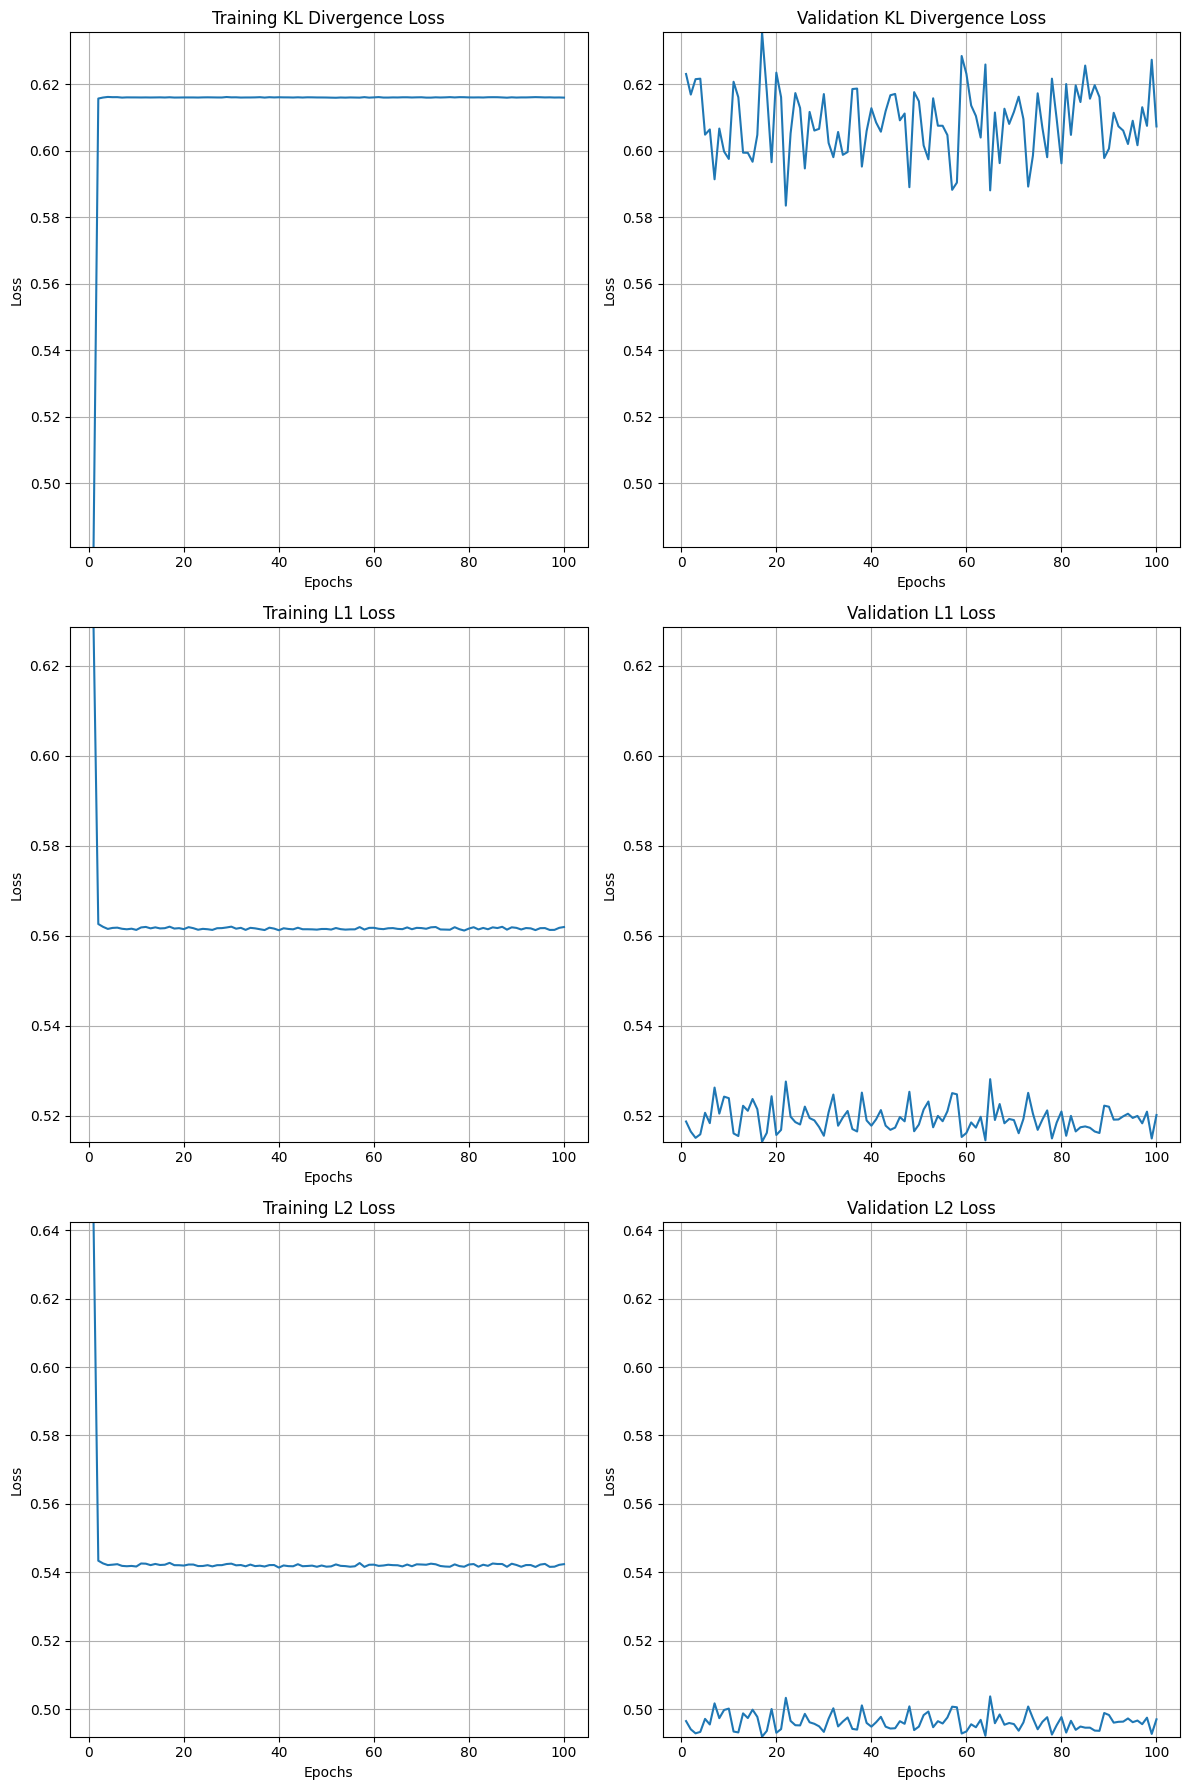

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
49.4016 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


z0: -0.0297
z1: -0.0701
z2: 0.0119
z3: -0.0333


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 716.07it/s]


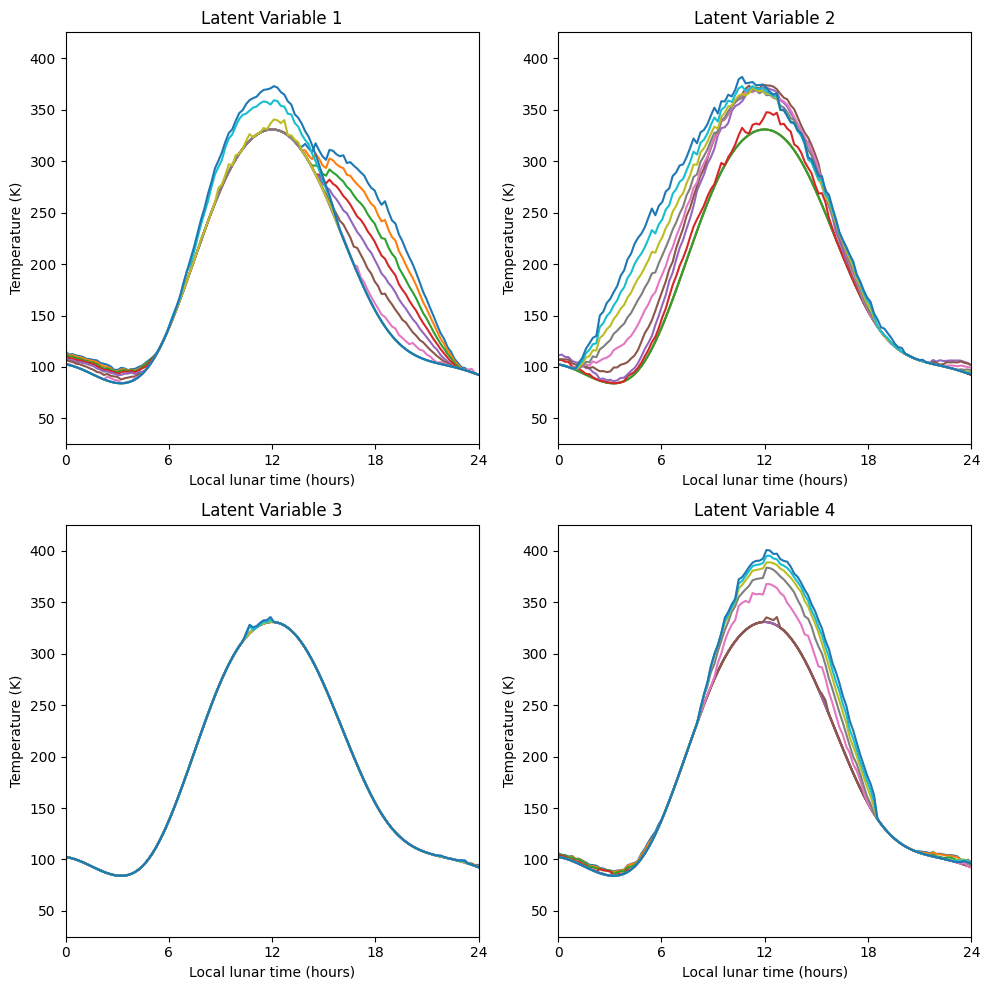

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)